# Load data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import shap  # https://github.com/slundberg/shap
import pickle
import random
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

### Breast Cancer Wisconsin (Diagnostic) Data Set

[Data source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

[data file](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data)

[feature info](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names)


#### Info about features
5. Number of instances: 569 

6. Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

7. Attribute information

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)

Several of the papers listed above contain detailed descriptions of
how these features are computed. 

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

8. Missing attribute values: none

9. Class distribution: 357 benign, 212 malignant

In [3]:
random_seed = 1234
random.seed(random_seed)
dataset_folder = Path("../../../datasets/breast_cancer_data/")

datapoint_names = ["radius", "texture", "perimeter", "area", "smoothness", "compactness",
              "concavity", "concave_points", "symmetry", "fractal_dimension"]

col_names = ["ID", "Dignosis"] + [item+"_mean" for item in datapoint_names] + \
            [item+"_se" for item in datapoint_names]+ [item+"_worst" for item in datapoint_names]

df = pd.read_csv(dataset_folder / "wdbc.data", header=None)
df.columns = col_names
df.shape
df.head()
df["Dignosis"].value_counts()


(569, 32)

,ID,Dignosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


B    357
M    212
Name: Dignosis, dtype: int64

In [4]:
x = df.drop(["ID", "Dignosis"], axis=1)
ss = StandardScaler()
ss.fit(x)
x_ss = ss.transform(x.values)
y = df["Dignosis"].replace({"M":1, "B":0}).values

num_features = x.shape[1]
feature_names = x.columns.tolist()

X_train, X_test, Y_train, Y_test = train_test_split(x_ss, y, test_size=0.1, random_state=random_seed)
X_trn, X_val, Y_trn, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

StandardScaler()

# Train model

In [5]:
model_file = Path("breast_diagnosis_model.pkl")
if model_file.is_file():
    print("Loading saved model")
    with open(model_file, "rb") as f:
        model = pickle.load(f)

else:
    model = GradientBoostingClassifier(n_estimators=1000,
                                       validation_fraction=0.2,
                                       n_iter_no_change=10, tol=0.01,
                                       random_state=random_seed)
    model.fit(X_train, Y_train)

    # Save model
    with open(model_file, "wb") as f:
        pickle.dump(model, f)
        
# model evaluation for testing set
print(f"The model type: {model.__class__.__name__}")
print("The model performance for testing set")
print("--------------------------------------")
y_predicted = model.predict(X_test)
print('accuracy {}'.format(accuracy_score(Y_test, y_predicted)))
print('Report {}'.format(classification_report(Y_test, y_predicted)))

Loading saved model
The model type: GradientBoostingClassifier
The model performance for testing set
--------------------------------------
accuracy 0.8947368421052632
Report               precision    recall  f1-score   support

           0       0.90      0.95      0.92        37
           1       0.89      0.80      0.84        20

    accuracy                           0.89        57
   macro avg       0.89      0.87      0.88        57
weighted avg       0.89      0.89      0.89        57



# Train surrogate

In [6]:
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss

In [7]:
# Select device
device = torch.device("cpu")

In [8]:
# Check for surrogate model
surrogate_file = Path("breast_diagnosis_surrogate.pt")
if surrogate_file.is_file():
    print('Loading saved surrogate model')
    surr = torch.load(surrogate_file).to(device)
    surrogate = Surrogate(surr, num_features)

else:
    # Create surrogate model
    surr = nn.Sequential(
        MaskLayer1d(value=0, append=True),
        nn.Linear(2 * num_features, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 2)).to(device)

    # Set up surrogate object
    surrogate = Surrogate(surr, num_features)

    # Set up original model
    def original_model(x):
        pred = model.predict(x.cpu().numpy())
        pred = np.stack([1 - pred, pred]).T
        return torch.tensor(pred, dtype=torch.float32, device=x.device)

    # Train
    surrogate.train_original_model(
        X_trn,
        X_val,
        original_model,
        batch_size=64,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        validation_samples=10,
        validation_batch_size=10000,
        verbose=True)

    # Save surrogate
    surr.cpu()
    torch.save(surr, surrogate_file)
    surr.to(device)

Loading saved surrogate model


# Train FastSHAP

In [9]:
from fastshap import FastSHAP

In [10]:
# Check for explainer model
explainer_file = Path("breast_diagnosis_explainer.pt")
if explainer_file.is_file():
    print('Loading saved explainer model')
    explainer = torch.load(explainer_file).to(device)
    fastshap = FastSHAP(explainer, surrogate, normalization='additive',
                        link=nn.Softmax(dim=-1))

else:
    # Create explainer model
    explainer = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2 * num_features)).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, normalization='additive',
                        link=nn.Softmax(dim=-1))

    # Train
    fastshap.train(
        X_trn,
        X_val,
        batch_size=32,
        num_samples=32,
        max_epochs=200,
        validation_samples=128,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, explainer_file)
    explainer.to(device)

Loading saved explainer model


# Compare with KernelSHAP

In [11]:
# Setup for KernelSHAP
def imputer(x, S):
    x = torch.tensor(x, dtype=torch.float32, device=device)
    S = torch.tensor(S, dtype=torch.float32, device=device)
    pred = surrogate(x, S).softmax(dim=-1)
    return pred.cpu().data.numpy()

In [12]:
# Select example
ind = np.random.choice(len(X_test))
# ind = 15
ind

x = X_test[ind:ind+1]
y = int(Y_test[ind])
y

9

1

In [13]:
# Run FastSHAP
fastshap_values = fastshap.shap_values(x)[0]

In [14]:
# Run KernelSHAP to convergence
game = shapreg.games.PredictionGame(imputer, x)
shap_values, all_results = shapreg.shapley.ShapleyRegression(
    game, batch_size=32, paired_sampling=False, detect_convergence=True,
    bar=True, return_all=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
%%time
# origial SHAP https://github.com/slundberg/shap
orig_explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_trn, 20))
orig_shap_values = orig_explainer.shap_values(x, nsamples=5000)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1.33 s, sys: 140 ms, total: 1.47 s
Wall time: 602 ms


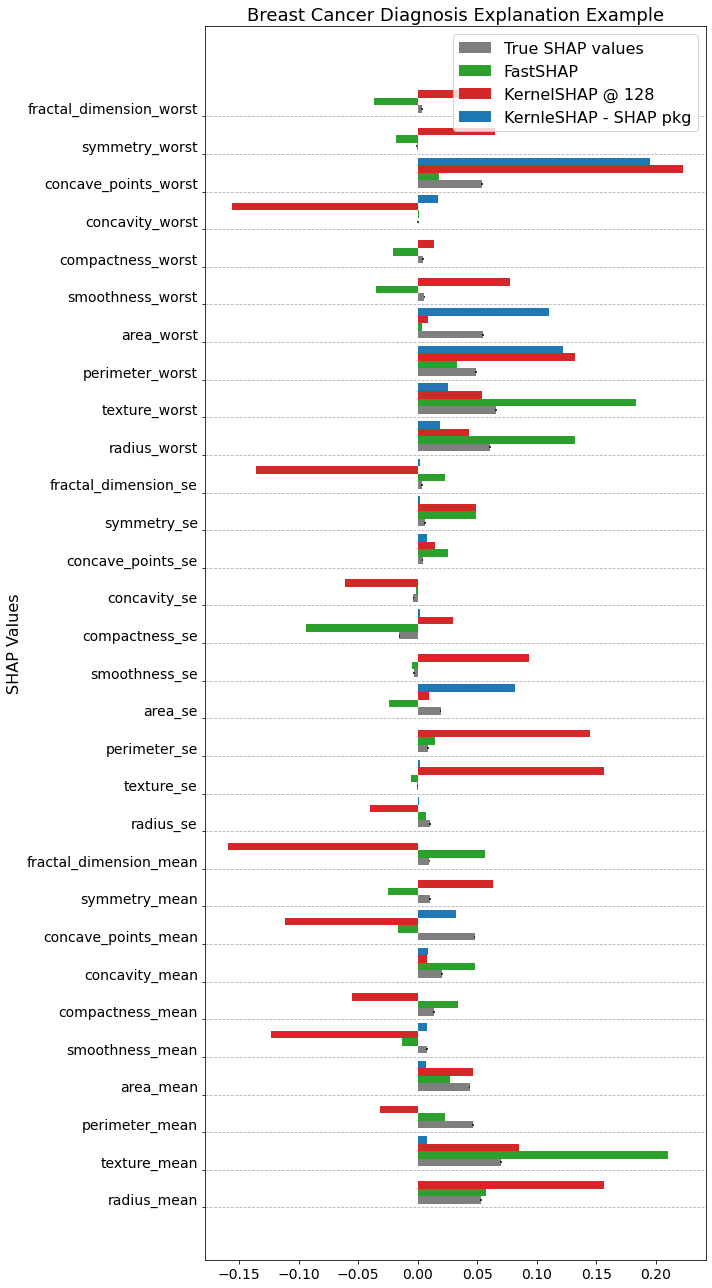

In [24]:
# Create figure
_ = plt.figure(figsize=(10, 18))

# Bar chart
width = 0.8
bar_width = width/4
kernelshap_iters = 128
kernel_shap_values = all_results['values'][list(all_results['iters']).index(kernelshap_iters)][:, y]

_ = plt.barh(np.arange(num_features) + bar_width*1, shap_values.values[:, y], xerr=shap_values.std[:, y], 
        height=bar_width, label='True SHAP values', color='tab:gray')
_ = plt.barh(np.arange(num_features) + bar_width*2, fastshap_values[:, y],
        height=bar_width, label='FastSHAP', color='tab:green')
_ = plt.barh(np.arange(num_features) + bar_width*3, kernel_shap_values,
        height=bar_width, label='KernelSHAP @ {}'.format(kernelshap_iters), color='tab:red')
_ = plt.barh(np.arange(num_features) + bar_width*4, orig_shap_values[0],
            bar_width, label='KernleSHAP - SHAP pkg', color='tab:blue')

# Annotations
_ = plt.legend(fontsize=16)
_ = plt.tick_params(labelsize=14)
_ = plt.ylabel('SHAP Values', fontsize=16)
_ = plt.title('Breast Cancer Diagnosis Explanation Example', fontsize=18)
_ = plt.yticks(np.arange(num_features), feature_names, va='bottom')

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()